<center><h1><u><font color="#1b5776"><b>Google Analytics Customer Revenue Prediction<b/></font></u></h1></center>

# <font color="#1b5776">1. <u>Introduction</u></font>

Every business nowadays is trying to become as much customer-centric as possible, by targeting customers for various marketing campaigns. This “targeting” is basically done on those customers which have helped the company to earn better/higher revenues in the past, and may have a specific pattern of using their business. Marketing teams are thus challenged to make appropriate investments for promotional strategies so as to target appropriate customers/users for suitable promotional strategies.</br>
This is essentially a Kaggle Competition ([Google Analytics Customer Revenue Prediction](https://www.kaggle.com/c/ga-customer-revenue-prediction)) organised by RStudio, GStore and Kaggle together.

# <font color="#1b5776">2. <u>Business Problem</u></font>

## <font color="#1b5776">2.1. <u>Overview</u></font>

It has been observed that most of the businesses earn the highest revenues from only a small percentage of people. This is referred to as the 80/20 rule. Here, we’ll be helping Google’s GStore ([Google’s Merchandize Store](https://shop.googlemerchandisestore.com/), where Google Swag is sold), to target customers who have helped to generate higher revenues in the past.

## <font color="#1b5776">2.2. <u>Problem Statement</u></font>

*   We are basically given various features (data) from when multiple customers logged in to the GStore or made purchases (wherein each customer has an unique ID) for a specific time-frame from the past.
*   We need to predict the revenue generated by some customers <b>in the future</b>, using the data given from the past.
* This will help GStore to focus more on a specific type of customers for various promotional/marketing strategies and plan budgets accordingly.






## <font color="#1b5776">2.3. <u>Real World / Business Objectives and Constraints</u></font>

*   No strict latency concerns: as promotional strategy is a well-organized & planned job. It won't demand prediction results in millisecond or even seconds range. As long as the prediction doesn't take days or months, we are good.
*   Too much of incorrect predictions may be costly: as companies spend millions of dollars for promotions, and investment for some incorrect set of customers may go in vain.
*   Interpretability is good to have: so that the marketing team has an overview as to why should they spend more on some set of customers and less on others.




# <font color="#1b5776">3. <u>Machine Learning Problem</u></font>

## <font color="#1b5776">3.1. <u>Data</u></font>

### <font color="#1b5776">3.1.1 <u>Data Overview</u></font>


*   train_v2.csv ➡ (uncompressed size= 25.41 GB) contains user transactions from August 1st 2016 to April 30th 2018.
*   test_v2.csv ➡ (uncompressed size= 7.62 GB) contains user transactions from May 1st 2018 to October 15th 2018.
*   sample_submission_v2.csv ➡ (uncompressed size= 7.08 MB) sample submission file. It lists all fullVisitorIDs from test_v2.csv whose logarithmic revenue we need to predict for the future time period 1st Dec,2018 to 31st Jan,2019.



### <font color="#1b5776">3.1.2 <u>Data Fields & Features</u></font>
📓 fullVisitorId- A unique identifier for each user of the Google Merchandise Store.</br>
📓 channelGrouping - The channel via which the user came to the Store.</br>
📓 date - The date on which the user visited the Store.</br>
📓 device - The specifications for the device used to access the Store.</br>
📓 geoNetwork - This section contains information about the geography of the user.</br>
📓 socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".</br>
📓 totals - This section contains aggregate values across the session.</br>
📓 trafficSource - This section contains information about the Traffic Source from which the session originated.</br>
📓 visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.</br>
📓 visitNumber - The session number for this user. If this is the first session, then this is set to 1.</br>
📓 visitStartTime - The timestamp (expressed as POSIX time).</br>
📓 hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.</br>
📓 customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.([A little overview on this feature](https://support.google.com/analytics/answer/2709828?hl=en#:~:text=Implementation%20considerations-,Overview,use%20them%20as%20Segments%20and%20secondary%20dimensions%20in%20standard%20reports.,-Prerequisites))</br>
📓 totals - This set of columns mostly includes high-level aggregate data.

## <font color="#1b5776">3.2. <u>Mapping the Real World problem to an ML problem</u></font>
* Type of ML problem: Time-series Forecasting & Regression
* What we need to predict: Our aim is to compute the logarithm of (total revenue generated by a visitor + 1) across all unique visitor IDs in submission_v2.csv, i.e. for each and every visitor in a future time-period (1st Dec,2018 to 31st Jan,2019) by using historical data (1st Aug,2016 to 15th Oct,2018) at hand. In short: <b>Our aim is to perform visitor-level prediction for future</b>.
* What we have as our actual target: We have revenue generated by visitors at session-level, i.e. transaction data every time some visitor logged in and performed or didn’t perform some transaction to buy some GStore merchandise.


## <font color="#1b5776">3.3. <u>Performance Metric</u></font>
* Metric given by Kaggle: 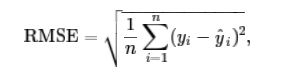Here, y is the natural log of the actual summed revenue plus 1 and y-hat is the natural log of the predicted revenue of a customer.

# <font color="#1b5776">4. <u>Adding Imports</u></font>

In [ ]:
# Since the size of data is large, we'll be using Dask here
# installing dask
!python -m pip install dask[dataframe] --upgrade

     |████████████████████████████████| 132 kB 4.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import json
from pandas import json_normalize
from tqdm import tqdm
from ast import literal_eval
import os

# <font color="#1b5776">5. <u>Preliminary Cleaning of the Data</u></font>

## <font color="#1b5776">5.1. <u>Getting the Data</u></font>

In [ ]:
# !pip install kaggle (in case kaggle isn't installed)
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# getting all datasets using Kaggle API
# all these are in zipped state
!kaggle competitions download -c ga-customer-revenue-prediction

  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 83.4MB/s]
 97% 322M/333M [00:11<00:00, 23.1MB/s]
100% 333M/333M [00:11<00:00, 29.5MB/s]
 67% 41.0M/61.1M [00:02<00:02, 9.44MB/s]
100% 61.1M/61.1M [00:02<00:00, 21.6MB/s]
 86% 49.0M/56.8M [00:02<00:00, 8.88MB/s]
100% 56.8M/56.8M [00:02<00:00, 20.4MB/s]
 96% 5.00M/5.23M [00:01<00:00, 3.99MB/s]
100% 5.23M/5.23M [00:01<00:00, 4.16MB/s]
100% 1.11G/1.11G [00:33<00:00, 27.5MB/s]
100% 1.11G/1.11G [00:33<00:00, 35.2MB/s]


We'll unzip only the v2.csv files as [these are the final updated files that was provided in the competition](https://www.kaggle.com/c/ga-customer-revenue-prediction/data#:~:text=What%20files%20do,in%20sample_submission_v2.csv.)

In [ ]:
%%time
!unzip /content/train_v2.csv.zip
!unzip /content/test_v2.csv.zip
!unzip /content/sample_submission_v2.csv.zip

Archive:  /content/train_v2.csv.zip
  inflating: train_v2.csv            
Archive:  /content/test_v2.csv.zip
  inflating: test_v2.csv             
Archive:  /content/sample_submission_v2.csv.zip
  inflating: sample_submission_v2.csv  
CPU times: user 1.91 s, sys: 292 ms, total: 2.2 s
Wall time: 4min 27s


## <font color="#1b5776">5.2. <u>Reading the csv files and flattening json object type columns</u></font>

In [ ]:
# referance: https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue
json_columns = ['device', 'geoNetwork','totals', 'trafficSource']  # columns having json blobs
# (note: we'll deal with the other 2 json columns: hits & customDimensions later)

def load_dataframe(filename):
  """
  Takes a csv file as input, Reads it using Dask, Flattens json based columns and returns a new dataframe with these new features.
  """
  parent_df = dd.read_csv(filename,
                   converters={column: json.loads for column in json_columns}, # loading the columns having json blobs as json object
                   dtype={'fullVisitorId': 'string'},  # setting the data type of fullVisitorId as string as it is a very large integer
                   )
  
  for column in tqdm(json_columns):
      column_as_df = json_normalize(parent_df[column]) # converts each json based column into a dataframe

      # note: the above dataframe: "column_as_df" will have column names as the keys of the json blob it had initially
      # for eg: the column: "device" (a json column) had the following 16 details as json keys across every row:-
      # browser	browserVersion	browserSize	operatingSystem	operatingSystemVersion	isMobile	mobileDeviceBranding	mobileDeviceModel
      # mobileInputSelector	mobileDeviceInfo	mobileDeviceMarketingName	flashVersion	language	screenColors	screenResolution	deviceCategory

      # hence, each json column, now loaded as a dataframe: "column_as_df" will have the above type of keys it had initially, as columns
      # modifying (by adding the main column name along with sub-column names) this dataframe's column names for ease of understanding:-
      column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]

      # dropping the main column as it is no longer needed
      # and merging with the new sub-dataframe "column_as_df" with the parent dataframe "parent_df" loaded from csv
      # note:- 
      # source: https://pandas.pydata.org/docs/reference/api/pandas.merge.html
      # left_index=True --> Use the index from the left DataFrame as the join key(s)
      # right_index=True --> Use the index from the right DataFrame as the join key(s)
      parent_df = parent_df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
  return parent_df

In [ ]:
%%time
print()
train = load_dataframe("/content/train_v2.csv")
print()
test = load_dataframe("/content/test_v2.csv")

100%|██████████| 4/4 [31:32<00:00, 473.03s/it]


100%|██████████| 4/4 [07:53<00:00, 118.25s/it]

CPU times: user 33min 57s, sys: 1min 54s, total: 35min 51s
Wall time: 39min 25s


In [ ]:
# overview of the train_v2.csv
train.head(2)

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,totals_visits,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,totals_sessionQualityDim,totals_timeOnSite,totals_transactions,totals_transactionRevenue,totals_totalTransactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adContent,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_campaignCode
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,NaN,NaN,2,28,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# overview of the test_v2.csv
test.head(2)

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,totals_visits,totals_hits,totals_pageviews,totals_timeOnSite,totals_sessionQualityDim,totals_newVisits,totals_transactions,totals_transactionRevenue,totals_totalTransactionRevenue,totals_bounces,trafficSource_referralPath,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adContent,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,7460955084541987166,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,1526099341,2,1526099341,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Asia,Southern Asia,India,Delhi,(not set),(not set),not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3,973,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),google,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,460252456180441002,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",Not Socially Engaged,1526064483,166,1526064483,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,San Francisco,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3,49,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),(direct),(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN


In [ ]:
# overview of the submission_v2.csv
submit = pd.read_csv("/content/sample_submission_v2.csv",dtype={'fullVisitorId': 'string'})
submit.head(2)

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.0
1,0000039738481224681,0.0


In [ ]:
# number of partitions in which this train dask dataframe is loaded as:-
train.npartitions

398

We need to deal with customDimensions column separately (since it is in a different format). Both: hits and customDimensions columns are in the form of list of dictionaries (python is not able to interpret them as json blobs like it is able to do with columns like totals,geoNetwork etc. since the keys are inside single quotes, whereas for json the keys must be inside double quotes).
Hence, if we try to load them as jsons, we get an error like: <b>JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 3 (char 2)</b>. More info on this can be obtained from [this stackoverflow discussion](https://stackoverflow.com/questions/39491420/python-jsonexpecting-property-name-enclosed-in-double-quotes).

In [ ]:
def modify_partitions(df):
  """
  Takes a dataframe and fetches data from a column which has data in the form of list of dictionary.
  """
  # convert string to list format
  convert_str_to_list = df.customDimensions.apply(literal_eval)
  
  # get the dict inside each list
  get_dict_from_list = convert_str_to_list.str[0] 
  
  # dealing with nan rows
  modify_nan_rows_of_dict = get_dict_from_list.apply(lambda x: {"index":np.nan, "value":np.nan} if pd.isna(x) else x)
  
  # flattening into dataframe format
  get_df = json_normalize(modify_nan_rows_of_dict)
  df["index"] = get_df["index"]
  df["value"] = get_df["value"]

  return df

In [ ]:
# Reason why we need to specify resulting data types in dask: is to help dask understand and perform an operation we are telling it to.
# source: https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.map_partitions.html#:~:text=An%20empty%20pd.DataFrame%20or%20pd.Series%20that%20matches%20the%20dtypes%20and%20column%20names%20of%20the%20output.%20This%20metadata%20is%20necessary%20for%20many%20algorithms%20in%20dask%20dataframe%20to%20work.
def get_data_type_dict(df):
  """
  Takes a dataframe and returns a list of tuples with the column name and its output data type we want.
  """
  meta_param = []
  for col in df.columns:
    meta_param.append((col,"string")) # telling dask to load everything as string for ease
  # note: index & value are the 2 more features we are going to get from customDimensions column
  meta_param.append(("index","string"))
  meta_param.append(("value","string"))
  return meta_param

meta_param_train = get_data_type_dict(train)
meta_param_test = get_data_type_dict(test)

In [ ]:
%%time
train = train.map_partitions(modify_partitions,meta=meta_param_train)

CPU times: user 16.4 ms, sys: 21 µs, total: 16.4 ms
Wall time: 16 ms


In [ ]:
%%time
test = test.map_partitions(modify_partitions,meta=meta_param_test)

CPU times: user 12.4 ms, sys: 19 µs, total: 12.4 ms
Wall time: 12.1 ms


In [ ]:
train.head(2)

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,totals_visits,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,totals_sessionQualityDim,totals_timeOnSite,totals_transactions,totals_transactionRevenue,totals_totalTransactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adContent,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_campaignCode,index,value
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,EMEA
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,NaN,NaN,2,28,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,North America


In [ ]:
test.head(2)

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,totals_visits,totals_hits,totals_pageviews,totals_timeOnSite,totals_sessionQualityDim,totals_newVisits,totals_transactions,totals_transactionRevenue,totals_totalTransactionRevenue,totals_bounces,trafficSource_referralPath,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adContent,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,index,value
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,7460955084541987166,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,1526099341,2,1526099341,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Asia,Southern Asia,India,Delhi,(not set),(not set),not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3,973,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),google,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,4,APAC
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,460252456180441002,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",Not Socially Engaged,1526064483,166,1526064483,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,San Francisco,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3,49,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),(direct),(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,4,North America


In [ ]:
# dropping these 2 columns since they are of no use now
# note: hits doesn't have any valuable info and has lots of missing data. So it's better to drop it
train = train.drop(columns=["hits","customDimensions"],axis=1)
test = test.drop(columns=["hits","customDimensions"],axis=1)

In [ ]:
train.head(2)

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,totals_visits,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,totals_sessionQualityDim,totals_timeOnSite,totals_transactions,totals_transactionRevenue,totals_totalTransactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adContent,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_campaignCode,index,value
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,EMEA
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,NaN,NaN,2,28,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,North America


In [ ]:
test.head(2)

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,totals_visits,totals_hits,totals_pageviews,totals_timeOnSite,totals_sessionQualityDim,totals_newVisits,totals_transactions,totals_transactionRevenue,totals_totalTransactionRevenue,totals_bounces,trafficSource_referralPath,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adContent,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,index,value
0,Organic Search,20180511,7460955084541987166,Not Socially Engaged,1526099341,2,1526099341,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Asia,Southern Asia,India,Delhi,(not set),(not set),not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3,973,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),google,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,4,APAC
1,Direct,20180511,460252456180441002,Not Socially Engaged,1526064483,166,1526064483,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,San Francisco,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3,49,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),(direct),(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,4,North America


In [ ]:
%%time
# saving the cleaned file
train.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/train_cleaned1.csv",single_file=True,index=False)

CPU times: user 11min 27s, sys: 38.1 s, total: 12min 5s
Wall time: 10min 7s


['/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/train_cleaned1.csv']

In [ ]:
%%time
# saving the cleaned file
test.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/test_cleaned1.csv",single_file=True,index=False)

CPU times: user 2min 52s, sys: 10.2 s, total: 3min 2s
Wall time: 2min 30s


['/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/test_cleaned1.csv']

In [ ]:
# some analysis on size of the files before and after the cleaning:-
print("train_v2.csv size=",os.path.getsize("/content/train_v2.csv") / (1e+9),"GB")
print("new train_v2.csv size=",os.path.getsize("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/train_cleaned1.csv") / (1e+9),"GB")

print("test_v2.csv size=",os.path.getsize("/content/test_v2.csv") / (1e+9),"GB")
print("new test_v2.csv size=",os.path.getsize("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/test_cleaned1.csv") / (1e+9),"GB")

train_v2.csv size= 25.412027988 GB
new train_v2.csv size= 1.405167266 GB
test_v2.csv size= 7.615592532 GB
new test_v2.csv size= 0.333909488 GB


Removal of "hits" column has led to this amazing drop in size! 😏
We can now comfortably load these files using the usual pandas library.

In [ ]:
# moving the identifer of visitors: fullVisitorId to front (for convenience)
new_train = pd.read_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/train_cleaned1.csv",dtype={'fullVisitorId': 'string'})
first_column_train = new_train.pop("fullVisitorId")
new_train.insert(0,"fullVisitorId",first_column_train)

new_test = pd.read_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/test_cleaned1.csv",dtype={'fullVisitorId': 'string'})
first_column_test = new_test.pop("fullVisitorId")
new_test.insert(0,"fullVisitorId",first_column_test)

In [ ]:
new_train.head(2)

,fullVisitorId,channelGrouping,date,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,totals_visits,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,totals_sessionQualityDim,totals_timeOnSite,totals_transactions,totals_transactionRevenue,totals_totalTransactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adContent,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_campaignCode,index,value
0,3162355547410993243,Organic Search,20171016,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,EMEA
1,8934116514970143966,Referral,20171016,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2.0,NaN,NaN,2.0,28.0,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,North America


In [ ]:
new_test.head(2)

,fullVisitorId,channelGrouping,date,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,totals_visits,totals_hits,totals_pageviews,totals_timeOnSite,totals_sessionQualityDim,totals_newVisits,totals_transactions,totals_transactionRevenue,totals_totalTransactionRevenue,totals_bounces,trafficSource_referralPath,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adContent,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,index,value
0,7460955084541987166,Organic Search,20180511,Not Socially Engaged,1526099341,2,1526099341,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Asia,Southern Asia,India,Delhi,(not set),(not set),not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3.0,973.0,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),google,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,4.0,APAC
1,460252456180441002,Direct,20180511,Not Socially Engaged,1526064483,166,1526064483,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,San Francisco,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3.0,49.0,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),(direct),(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,4.0,North America


In [ ]:
%%time
# saving these files again:-
new_train.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/train_cleaned2.csv",index=False)

new_test.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/test_cleaned2.csv",index=False)

CPU times: user 1min 9s, sys: 4.47 s, total: 1min 13s
Wall time: 1min 23s
